# Augment dataset

In this notebook we exemplify how to augment a dataset. This is tipically done to increase the number and/or representativity of trainining sets.

#### Index<a name="index"></a>
1. [Import Packages](#imports)
2. [Load Dataset](#loadData)
    1. [GP Path](#oriGpPath)
3. [Augment Dataset](#augData)
    1. [Choose the Events to Augment](#chooseEvent)
    3. [Choose the Photometric Redshift](#choosePhotoZ)
    4. [Run Augmentation](#aug)
    5. [See Augmented Dataset Properties](#statsAug)
4. [Save Augmented Dataset](#saveAug)
5. [Light curve comparison](#comparison)

## 1. Import Packages<a name="imports"></a>

In [1]:
import collections
import os
import pickle
import sys
import time

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from snmachine import snaugment, sndata
from utils.plasticc_pipeline import get_directories, load_dataset

No module named 'pymultinest'

                PyMultinest not found. If you would like to use, please install
                Mulitnest with 'sh install/multinest_install.sh; source
                install/setup.sh'
                


In [4]:
%config Completer.use_jedi = False  # enable autocomplete

#### Aestetic settings

In [5]:
%matplotlib inline

sns.set(font_scale=1.3, style="ticks")

## 2. Load Dataset<a name="loadData"></a>

First, **write** the path to the folder that contains the dataset we want to augment, `folder_path`.

In [6]:
folder_path = '../snmachine/example_data'

Then, **write** in `data_file_name` the name of the file where your dataset is saved.

In this notebook we use the dataset saved in [2_preprocess_data]().

In [7]:
data_file_name = 'example_dataset_gapless50.pckl'

Load the dataset.

In [8]:
data_path = os.path.join(folder_path, data_file_name)
dataset = load_dataset(data_path)

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x7f5a55acc2d0>


### 2.1. GP Path<a name="oriGpPath"></a>

The GP augmentation uses the previously saved GPs, so **write** the path where they were saved. For help in fitting GPs to the dataset, follow [3_model_lightcurves](3_model_lightcurves.ipynb).

**<font color=Orange>A)</font>** Obtain GP path from folder structure.

If you created a folder structure, you can obtain the path from there. **Write** the name of the folder in `analysis_name`. 

In [9]:
analysis_name = data_file_name[:-5]

Obtain the required GP path.

In [10]:
directories = get_directories(folder_path, analysis_name) 
path_saved_gps = directories['intermediate_files_directory']

**<font color=Orange>B)</font>** Directly **write** where you saved the GP files.

```python
path_saved_gps = os.path.join(folder_path, data_file_name[:-5])
```

## 3. Augment Dataset<a name="augData"></a>

Here we augment the data and make sure all the properties have the expected values.

In the following sections we decide the following augmentation inputs: 
1. `objs_number_to_aug` : a dictionary specifying which events to augment and by how much.
2. `choose_z` : function used to choose the new true redshift of the augmented events.
3. `z_table` : dataset containing the spectroscopic and photometric redshift, and photometric redshift error of events; it is used to generate realistic augmented photometric redshifts.
4. `max_duration` : maximum duration of the augmented light curves.
5. `random_seed` : random seed used; saving this seed allows reproducible results.

### 3.1. Choose the Events to Augment<a name="chooseEvent"></a>

**Write** in `aug_obj_names` a list containing all the events to augment. Here we will try to augment them all.

In [11]:
aug_obj_names = dataset.object_names  # try to augment all events

**Create** a dictionary that associates to each event, the target number of synthetic events to create from it. Note that some augmentations will fail so this is not the final number of events. Additionally, each class has a different creation efficiency.

In [12]:
np.random.seed(42)
is_to_aug = np.in1d(dataset.object_names, aug_obj_names)

# Choose the target number of events in the augmented dataset. 
# Usually, only half of this number are accepted in the augmented dataset
target_number_aug = np.sum(is_to_aug) * 2

number_objs_per_label = collections.Counter(dataset.labels[is_to_aug])
number_aug_per_label = target_number_aug//len(number_objs_per_label.keys())
objs_number_to_aug = {}
for label in number_objs_per_label.keys():
    is_label = dataset.labels[is_to_aug] == label
    aug_is_label_obj_names = aug_obj_names[is_label]
    number_aug_per_obj = number_aug_per_label // np.sum(is_label)
    number_extra_aug_per_obj = number_aug_per_label % np.sum(is_label)
    extra_obj = np.random.choice(aug_is_label_obj_names, size=number_extra_aug_per_obj, 
                                 replace=False)
    objs_number_to_aug.update({obj: number_aug_per_obj for obj in aug_is_label_obj_names})
    objs_number_to_aug.update({obj: number_aug_per_obj+1 for obj in extra_obj})

In [13]:
print(f'We aim to create up to {sum(objs_number_to_aug.values())} events.')  # confirm how many events to create

We aim to create up to 180 events.


### 3.2. Choose the Photometric Redshift<a name="choosePhotoZ"></a>

In order to simulate realistic photometric redshifts for the synthetic events, following [Boone (2019)](https://iopscience.iop.org/article/10.3847/1538-3881/ab5182) we chose a random event from the test set events that had a spectroscopic redshift measurement, and calculated the difference between its spectroscopic and photometric redshifts. We then added this difference to the true redshift of the augmented event to generate a photometric redshift. 

**Add** such a dataset containing spectroscopic and photometric redshift, and photometric redshift error of events as `z_table`. If none is provided, a similar table is generated from the events in `dataset`.

In [14]:
test_data_file_name = 'example_test_dataset.pckl'
test_data_path = os.path.join(folder_path, test_data_file_name)

test_data = load_dataset(test_data_path)
test_metadata = test_data.metadata

# Discard the events without spectroscopic redshift; 
# these are encoded with `hostgal_specz` equal to -9
z_table = test_metadata[test_metadata.hostgal_specz > -2]

Opening from binary pickle
Dataset loaded from pickle file as: <snmachine.sndata.PlasticcData object at 0x7f5a55acc290>


### 3.3. Run Augmentation<a name="aug"></a>

We also need to choose which survey to emulate in the augmentation. At the moment `snmachine` contains the Wide-Fast-Deep (WFD) and the Deep Drilling Field (DDF) survey of the Rubin Observatory Legacy Survey of Space and Time. Use `snaugment.PlasticcWFDAugment` for the former survey and `snaugment.PlasticcDDFAugment` for the latter.
You can also implement your own augmentation using those classes as an example.

In addition to the above inputs, we **chose** the random seed (`random_seed`) used to allow reproducible results and the maximum duration of the augmented light curves (`max_duration`).

The value of `max_duration` must be higher than the maximum duration of any light curve in `dataset`. If none is provided, `max_duration` is set to the length of the longest event in `dataset`.

In [15]:
print(f'The longest event in `dataset` has {dataset.get_max_length():.2f} days.')

The longest event in `dataset` has 271.56 days.


In [16]:
random_seed = 42 
max_duration = 278  # this is the length of the longest event in the PLAsTiCC SNe dataset

Here we augmented following the WFD survey.

In [17]:
aug = snaugment.PlasticcWFDAugment(dataset=dataset, path_saved_gps=path_saved_gps, 
                                   objs_number_to_aug=objs_number_to_aug,
                                   random_seed=random_seed, max_duration=max_duration, 
                                   z_table=z_table)

In [18]:
aug.augment()

Augmenting the dataset...
Time spent augmenting: 0 days 00:00:55.


Go to:
* [Index](#index)
* [Save Augmented Dataset](#saveAug)
  
### 3.4. See Augmented Dataset Properties<a name="statsAug"></a>

Here we see some properties of the augmented dataset. 

In [19]:
try:  # a test set was provided
    test_metadata['target'] = test_metadata['true_target']
    datasets_label = ['Original', 'Only Aug.', 'Test data']
    datasets_metadata = [aug.dataset.metadata, aug.only_new_dataset.metadata, test_metadata]
except NameError:   # no test set was provided
    datasets_label = ['Original', 'Only Aug.']
    datasets_metadata = [aug.dataset.metadata, aug.only_new_dataset.metadata]

In [20]:
print(f'The longest event in the augmented dataset (`aug.only_new_dataset`)'
      f' has {aug.only_new_dataset.get_max_length():.2f} days.')

The longest event in the augmented dataset (`aug.only_new_dataset`) has 268.10 days.


In [21]:
print(f'In total we generated {len(aug.only_new_dataset.object_names)} events.')

In total we generated 62 events.


Note that we generated less events than our target number of augmented events. As mentioned in Section [Choose the Events to Augment](#chooseEvent), some of the augmentations fail.

In [22]:
print('{:^12}  {:^12}  {:^12}  {:^12}'.format('Dataset', 'total # objs', '# DDF objs', '% DDF objs'))
print('-'*(12*4 + 3*2))
for i in np.arange(len(datasets_label)):
    is_ddf = datasets_metadata[i]['ddf'] == 1
    number_total_objs = len(is_ddf)
    number_ddf_objs = np.sum(is_ddf)
    print('{:^12} {:^12} {:^12} {:^12.2f}'.format(
        datasets_label[i], number_total_objs, number_ddf_objs, 
        number_ddf_objs/number_total_objs * 100))

  Dataset     total # objs   # DDF objs    % DDF objs 
------------------------------------------------------
  Original        90           23         25.56    
 Only Aug.        62           0           0.00    
 Test data       5000          0           0.00    


We now see the distribution of the photometric redshift.

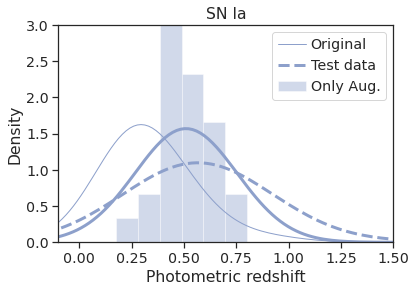

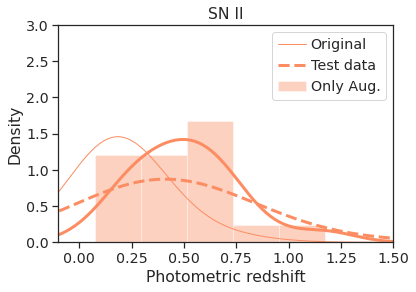

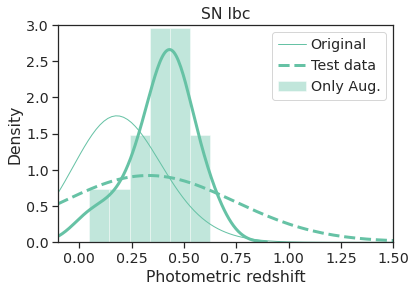

In [23]:
# Plotting choices
diverg_color = sns.color_palette("Set2", 3, desat=1)
sn_type_color = {42: diverg_color[1], 62: diverg_color[0], 90: diverg_color[2]}
sn_type_name = {42: 'SN II', 62: 'SN Ibc', 90: 'SN Ia'}
unique_types = [90, 42, 62]
datasets_ls = ['-', '-', '--']
datasets_linewidth = [1, 3, 3]
datasets_bw_adjust = [.3, .8, .8]

# Plot the redshift distribution
for sn_type in unique_types: # sns scale 2
    plt.figure()
    for i, metadata in enumerate(datasets_metadata):
        label = datasets_label[i]
        ls = datasets_ls[i]
        linewidth = datasets_linewidth[i]
        bw_adjust= datasets_bw_adjust[i]
        is_sn_type = (metadata['target'] == sn_type)
        sn_type_metadata = metadata[is_sn_type]
        try:
            sns.kdeplot(data=sn_type_metadata['hostgal_photoz'],
                        label=label, color=sn_type_color[sn_type],
                        linestyle=ls, linewidth=linewidth, 
                        bw=bw_adjust)
        except ValueError:  # outdated version of matplotlib
            sns.distplot(a=sn_type_metadata['hostgal_photoz'], 
                         label=label, color=sn_type_color[sn_type],
                         kde_kws={'linestyle': ls, 
                                  'linewidth': linewidth})
    sn_name = sn_type_name[sn_type]
    plt.title(sn_name)
    plt.xlim(-.1, 1.5)
    plt.ylim(0, 3)
    plt.xlabel('Photometric redshift')
    plt.ylabel('Density')
    plt.legend(handletextpad=.3)

## 4. Save Augmented Dataset<a name="saveAug"></a>

Now, we save the `PlasticcData` instance containing only the augmented events. **Chose** a path to save (`folder_path_to_save`) and the name of the file (`file_name`).

In [24]:
folder_path_to_save = folder_path
file_name = 'example_dataset_aug.pckl'

At this point we could also choose to save only part of the augmented dataset. Here we save all the augmented events.

**Add** an extra step to select your chosen subset. See the notebook [1_load_data](1_load_data.ipynb) for a tutorial on how to select a subset from a `PlasticcData` instance. This can be used, for example, to create an augmented training set with the same number of events in each class. For a working example of how to balance the augmented training set, see the notebook [example_plasticc](example_plasticc.ipynb).

Finally, save the `PlasticcData` instance.

In [25]:
only_aug_dataset = aug.only_new_dataset

path_to_save = os.path.join(folder_path_to_save, file_name)
with open(path_to_save, 'wb') as f:
    pickle.dump(only_aug_dataset, f, pickle.HIGHEST_PROTOCOL)

## 5. Light curve visualization<a name="see"></a>

Here we show the light curve of an event along with one of the synthetic events generated from it.

Text(0.5, 1.0, 'Event 47712228; z = 0.157')

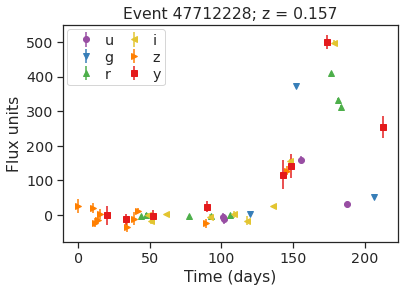

In [26]:
obj_show = '47712228'
sndata.PlasticcData.plot_obj_and_model(dataset.data[obj_show])
plt.title(f'Event {obj_show}; z = {dataset.data[obj_show].meta["z"]:.3f}')

Text(0.5, 1.0, 'Event 47712228_aug1; z = 0.128')

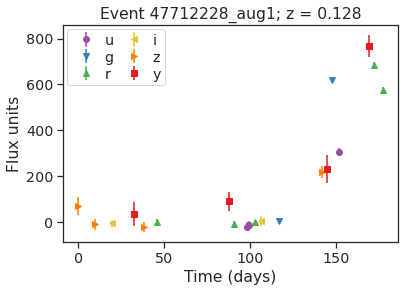

In [27]:
obj_aug_show = obj_show + '_aug1'
sndata.PlasticcData.plot_obj_and_model(only_aug_dataset.data[obj_aug_show])
plt.title(f'Event {obj_aug_show}; z = {only_aug_dataset.data[obj_aug_show].meta["z"]:.3f}')

[Go back to top.](#index)

*Previous notebook:* [3_model_lightcurves](3_model_lightcurves.ipynb)

**Next notebook:** [5_feature_extraction](5_feature_extraction.ipynb)